In [1]:
import numpy as np
import sys
sys.path.append("../")
from algorithm.koopmanlib.dictionary import PsiNN

In [2]:
basis_function = PsiNN(layer_sizes=[100,100,100], n_psi_train=25)

In [3]:
from duffing_oscillator import duffing_oscillator
from scipy.integrate import solve_ivp

# Parameters
delta = 0.5
alpha = -1
beta = 1

# Sample N=1000 initial points, with uniform distribution [-2, 2].
N = 1000
np.random.seed(39)
sample_data_x0 = (np.random.rand(N, 2) * 4) - 2

tspan = [0, 2.5]
nstep = 11
data = np.zeros((N, 2, nstep))

t_eval = np.linspace(tspan[0], tspan[1], nstep)

for idx, x0 in enumerate(sample_data_x0):
    sol = solve_ivp(duffing_oscillator, tspan, x0, t_eval=t_eval, args=(delta, alpha, beta))
    data[idx, 0, :] = sol.y[0]
    data[idx, 1, :] = sol.y[1]

# Pairwise shifted data X and Y
X = data[:, :, :-1] # shape: (1000, 2, 10)
Y = data[:, :, 1:]

# Transpose and reshape the data.
X = np.transpose(X, (0, 2, 1)).reshape(N * (nstep-1), 2) # shape: (10000, 2)
Y = np.transpose(Y, (0, 2, 1)).reshape(N * (nstep-1), 2)

In [4]:
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all),:]
data_x_valid = X[int(0.7*len_all)+1:,:]

data_y_train = Y[:int(0.7*len_all),:]
data_y_valid = Y[int(0.7*len_all)+1:,:]

In [5]:
data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

In [6]:
## Using solver 0,3,4
from algorithm.koopmanlib.solver_4 import KoopmanDLSolver # resDMD solver using regression
solver = KoopmanDLSolver(dic=basis_function,
                         target_dim=np.shape(data_train)[-1],
                         reg=0.1)

solver.build(data_train=data_train,
             data_valid=data_valid,
             epochs=100,
             batch_size=5000,
             lr=1e-4,
             log_interval=10,
             lr_decay_factor=.8)

Epoch 1/2
2/2 [==============================] - 3s 550ms/step - loss: 0.1670 - val_loss: 0.1260
Epoch 2/2
2/2 [==============================] - 0s 71ms/step - loss: 0.1333 - val_loss: 0.1072
number of the outer loop: 0
Epoch 1/2
2/2 [==============================] - 0s 100ms/step - loss: 0.1219 - val_loss: 0.0909
Epoch 2/2
2/2 [==============================] - 0s 72ms/step - loss: 0.1077 - val_loss: 0.0739
number of the outer loop: 1
Epoch 1/2
2/2 [==============================] - 0s 94ms/step - loss: 0.1212 - val_loss: 0.0672
Epoch 2/2
2/2 [==============================] - 0s 76ms/step - loss: 0.0764 - val_loss: 0.0667
number of the outer loop: 2
Epoch 1/2
2/2 [==============================] - 0s 92ms/step - loss: 0.0823 - val_loss: 0.0660
Epoch 2/2
2/2 [==============================] - 0s 71ms/step - loss: 0.0719 - val_loss: 0.0674
number of the outer loop: 3
Epoch 1/2
2/2 [==============================] - 0s 89ms/step - loss: 0.0718 - val_loss: 0.0630
Epoch 2/2
2/2 [=======

(7000, 28)
(10000, 28)
<class 'numpy.ndarray'>


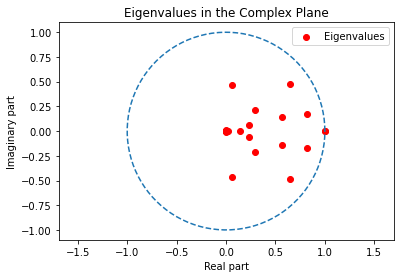

Is Psi_X orthonormal? False
Is Psi_Y orthonormal? False
Are the columns of Psi_X normalized? True
Are the columns of Psi_Y normalized? True


In [7]:
## Results from solver
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X, Psi_Y = solver.get_basis(data_train[0], data_train[1])
# # Build the Koopman model (this will compute the Koopman matrix K and store it in self.K_reg)
# solver.build(data_train)
# After building the model, you can access the Koopman matrix K
Koopman_matrix_K = solver.K_reg.numpy()

resDMD_DL_outputs = {
    'resDMD_DL_outputs': {
        'efuns': efuns,
        'evalues': evalues,
        'kpm_modes': kpm_modes,
        'N_dict': N_dict,
        'Psi_X': Psi_X,
        'Psi_Y': Psi_Y,
        'K': Koopman_matrix_K,  # Add the Koopman matrix K to the results
    }
}

print(resDMD_DL_outputs['resDMD_DL_outputs']['Psi_X'].shape)
print(resDMD_DL_outputs['resDMD_DL_outputs']['efuns'].shape)
print(type(resDMD_DL_outputs['resDMD_DL_outputs']['K']))

## Plot eigenvalues
import matplotlib.pyplot as plt

# Plot the unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='dashed')

# Plot the real and imaginary parts of the eigenvalues
plt.scatter(evalues.real, evalues.imag, color='red', label='Eigenvalues')

# Set equal scaling for both axes
plt.axis('equal')

# Set the labels
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Eigenvalues in the Complex Plane')

# Enable the legend
plt.legend()

# Show the plot
plt.show()

## Check if basis is orthonormal or normailized.
def is_orthonormal(A, tol=1e-6):
    # A should be orthonormal if A' * A = I
    A_H = np.conj(A).T  # Conjugate transpose for complex-valued A
    product = np.dot(A_H, A)
    I = np.eye(A.shape[1])  # Identity matrix
    return np.allclose(product, I, atol=tol)

# Now, use this function to check orthonormality of Psi_X and Psi_Y
print("Is Psi_X orthonormal?", is_orthonormal(Psi_X))
print("Is Psi_Y orthonormal?", is_orthonormal(Psi_Y))

def are_columns_normalized(A, tol=1e-6):
    # Calculate the norm of each column
    norms = np.linalg.norm(A, axis=0)
    # Check if each norm is close to 1 within the specified tolerance
    return np.allclose(norms, 1, atol=tol)

# Now, use this function to check the normalization of Psi_X and Psi_Y
print("Are the columns of Psi_X normalized?", are_columns_normalized(Psi_X))
print("Are the columns of Psi_Y normalized?", are_columns_normalized(Psi_Y))